# Previsão de venda de carro.

---

**Empresa ficticia**

### COMPRACAR

A COMPRACAR atua no mercado automobilístico, caracterizada por ser uma empresa sólida, de tradição, que conjuga excelência no atendimento e veículos com rigorosa qualidade, com o objetivo único de tornar real o sonho de cada cliente.

Apostando em confiança e credibilidade como princípios fundamentais de sua atuação, a empresa busca no mercado somente veículos diferenciados, através de um rigoroso critério técnico de avaliação que garante qualidade e procedência.

A loja oferece automóveis de diversas marcas, semi-novos, Nacionais e Importados. Todos criteriosamente testados e avaliados, característica que a revenda traz consigo até hoje e a diferencia no mercado. E é assim que a COMPRACAR solidificou a sua marca, com uma conduta ética e respeito a seus clientes, parceiros e fornecedores.

## Checklist das Etapas

1. Definindo o problema.
2. Captação dos dados.
3. Análise exploratória dos dados.
4. Preparação dos dados.
5. Construção do modelo de Machine Learning.
6. Avaliação do modelo.

## 1. Definindo o problema.

Desde 2012, o faturamento da empresa COMPRACAR vem oscilando frequentemente, o que deixou o dono alerta para começar a implementar possíveis mudanças no gerenciamento e na forma de lidar com o cliente. Porém, a partir do ano de 2016 vem acumulando  prejuízos.

O dono modernizou a empresa, criou site, estudou a concorrência e contratou melhores profissionais. No começo, essas mudanças tiveram um impacto significativo, porém não chegou no nível desejável. Foi então que o dono teve a ideia de que o maior problema era a compra de um carro que não tinha potencial para ser revendido com o valor desejado. 

Para conseguir solucionar esse problema, através de amigos e buscas na internet, conheceu o serviço de consultoria em ciência de dados  que prometia realizar essa análise e dizer o potencial do carro em ser revendido por um preço pré-determinado através de dados históricos.

### Objetivo

O objetivo é analisar os dados históricos da venda ou não venda dos carros da empresa em conjunto de algumas outras variáveis para determinar se o carro é potencialmente bom para revenda quando as variáveis forem imputadas.
O nível de acurácia requerido pelo dono é de no mínimo 70%.

## 2. Caletando dos dados.

Dados disponibilizados pela Alura Cursos, que estão acessível [neste link](https://github.com/rodrigogaf01/prev-venda-carros/blob/main/car-prices.csv).

In [1]:
# Importando os pacotes de manipulação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
import pickle

# Simulador
from ipywidgets import widgets, HBox, VBox
from IPython.display import display

In [2]:
# importando os dados
dados= pd.read_csv('https://raw.githubusercontent.com/rodrigogaf01/prev-venda-carros/main/car-prices.csv')
dados.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


In [3]:
print('Numero de linhas  : {}'.format(dados.shape[0]))
print('Numeros de Colunas: {}'.format(dados.shape[1]))

Numero de linhas  : 10000
Numeros de Colunas: 5


### Configurando Dataset

Vamos fazer algumas modificações no dataset atual para melhorar a sua manipulação e ficar mais fácil a compreensão de quem for analisar.

- Traduzir as colunas e mudar a medida de Milhas para Kilômetros.
- Ao invés de trabalhar com o ano do modelo, trabalharemos com a idade do carro.
- Mudar os valores da coluna 'vendido' para valores numéricos.
- Após as mudanças acima, iremos excluir as colunas que não serão utilizadas.

In [4]:
# Criando novas colunas
dados['idade_carro']= datetime.today().year - dados.model_year     # Pegando a idade do carro. Ano atual 2021.
dados['km_por_ano']= dados.mileage_per_year * 1.60934              # Passando milhas para Kilômetros.


# Traduzindo colunas em inglês
colunas= {'price': 'preco', 'sold': 'vendido'}
dados.rename(columns= colunas, inplace= True)

# Excluindo colunas
dados.drop(columns= ['Unnamed: 0', 'mileage_per_year', 'model_year'], inplace= True)  # Colunas que não serão utilizadas


dados.head()

,preco,vendido,idade_carro,km_por_ano
0,30941.02,yes,21,35085.22134
1,40557.96,yes,23,12622.05362
2,89627.50,no,15,11440.79806
3,95276.14,no,6,43167.32682
4,117384.68,yes,7,12770.11290


## 3. Análise exploratória dos dados

Na análise inicial, toda variável deve ser estudada. É importante analisar o nome, tipo, valores faltantes, presença de outliers e o tipo de distribuição.

Como neste caso o objetivo é saber se o carro é potencialmente bom para a sua revenda, a variável ```vendido``` será definida como variável alvo.

### Variáveis

* **vendido:** Informa se o carro foi vendido ou não.
    * no = Não
    * yes = Sim
* **preco:** Preço do carro a ser revendido.
* **idade_carro:** Idade do carro.
* **km_por_ano:** Kilometragem que o carro fez por ano em média.

**Qual o tipo para cada variável ?**

* **Variáveis Quantitativas**

   * Discreta
        * Não possui variável Discreta
   * Continua
        * preco
        * idade_carro
        * km_por_ano
   * Alvo
        * vendido
        
* **Variáveis Categóricas**
    
    * Não possui variáveis categóricas.
   

In [5]:
print(dados.dtypes)
dados.head()

preco          float64
vendido         object
idade_carro      int64
km_por_ano     float64
dtype: object


,preco,vendido,idade_carro,km_por_ano
0,30941.02,yes,21,35085.22134
1,40557.96,yes,23,12622.05362
2,89627.50,no,15,11440.79806
3,95276.14,no,6,43167.32682
4,117384.68,yes,7,12770.11290


In [6]:
# Verificando se existem valores nulos
dados.isna().sum()

preco          0
vendido        0
idade_carro    0
km_por_ano     0
dtype: int64

In [7]:
# Distribuição estatística
dados.describe()

,preco,idade_carro,km_por_ano
count,10000.000000,10000.00000,10000.000000
mean,64842.373698,16.85580,22825.898794
std,25250.592393,4.68758,8060.494332
min,-840.360000,4.00000,584.190420
25%,44796.375000,14.00000,16857.434165
50%,65225.685000,18.00000,21594.928790
75%,85111.237500,21.00000,27643.230845
max,118929.720000,23.00000,63684.802480


In [8]:
# É possível visualizar que existe preço negativo, o que não é possivel. Vamos localizá-los.
dados[dados.preco < 0]

,preco,vendido,idade_carro,km_por_ano
4200,-270.77,yes,23,27358.78000
4796,-840.36,yes,23,21367.20718


In [9]:
# Por se tratar de apenas duas linhas, vamos removê-las.
dados.drop(index= [4200, 4796], inplace= True)

# Ajeitando o index
dados.index= range(len(dados))

dados

,preco,vendido,idade_carro,km_por_ano
0,30941.02,yes,21,35085.22134
1,40557.96,yes,23,12622.05362
2,89627.50,no,15,11440.79806
3,95276.14,no,6,43167.32682
4,117384.68,yes,7,12770.11290
...,...,...,...,...
9993,97112.86,no,15,25060.64248
9994,107424.63,yes,19,21317.31764
9995,93856.99,no,7,20950.38812
9996,51250.57,yes,10,16840.13376


In [10]:
dados.describe().round(2)

,preco,idade_carro,km_por_ano
count,9998.00,9998.00,9998.00
mean,64855.46,16.85,22825.59
std,25236.17,4.69,8061.16
min,1757.97,4.00,584.19
25%,44807.54,14.00,16856.63
50%,65227.91,18.00,21594.93
75%,85115.85,21.00,27645.64
max,118929.72,23.00,63684.80


In [11]:
print('Contagem Sim/Não')
print(dados.vendido.value_counts())
print('')
print('Porcentagem Sim/Não')
print((dados.vendido.value_counts(normalize= True)*100).round(2))

Contagem Sim/Não
yes    5798
no     4200
Name: vendido, dtype: int64

Porcentagem Sim/Não
yes    57.99
no     42.01
Name: vendido, dtype: float64


**Insights**

- A mediana e a média do preco são bem próximas, onde o preço médio dos carros é de R$ 64.855,46 e a mediana é de RS 65.227,91.
- O primeiro quartil dos dados apresentam idade de até 14 anos, ou seja 75% dos carros estão acima dessa idade.
- 58% dos carros deste dataset foram revendidos.

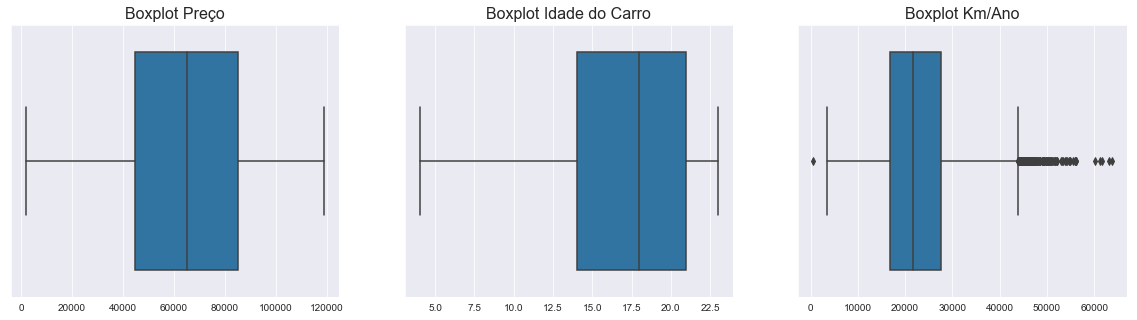

In [12]:
sns.set_style('darkgrid')
def boxplot(titulo, x, dados):
    ax= sns.boxplot(x= x, data= dados)
    ax.set_xlabel('')
    ax.set_title(titulo, fontsize= 16)

plt.figure(figsize= (20,5))
plt.subplot(1, 3, 1)
boxplot('Boxplot Preço', 'preco', dados)

plt.subplot(1, 3, 2)
boxplot('Boxplot Idade do Carro', 'idade_carro', dados)

plt.subplot(1, 3, 3)
boxplot('Boxplot Km/Ano', 'km_por_ano', dados)

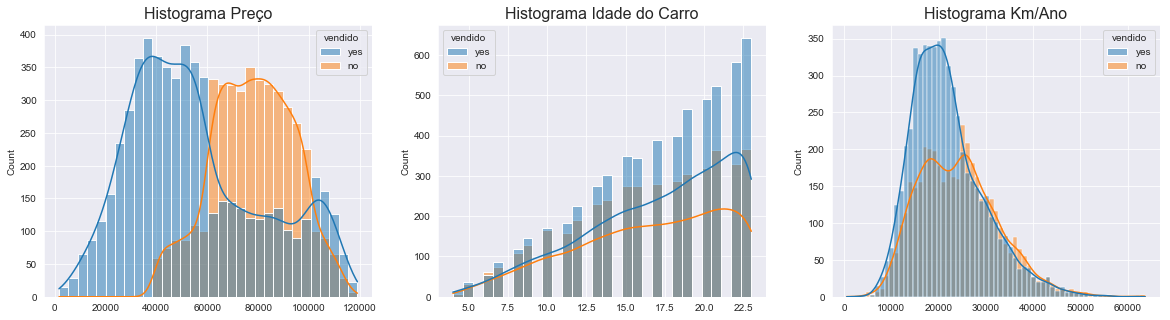

In [13]:
def hist(titulo, x, dados):
    ax= sns.histplot(x= x, data= dados, kde= True, hue= 'vendido')
    ax.set_xlabel('')
    ax.set_title(titulo, fontsize= 16)
    
plt.figure(figsize= (20,5))
plt.subplot(1, 3, 1)
hist('Histograma Preço', 'preco', dados)

plt.subplot(1, 3, 2)
hist('Histograma Idade do Carro', 'idade_carro', dados)

plt.subplot(1, 3, 3)
hist('Histograma Km/Ano', 'km_por_ano', dados)

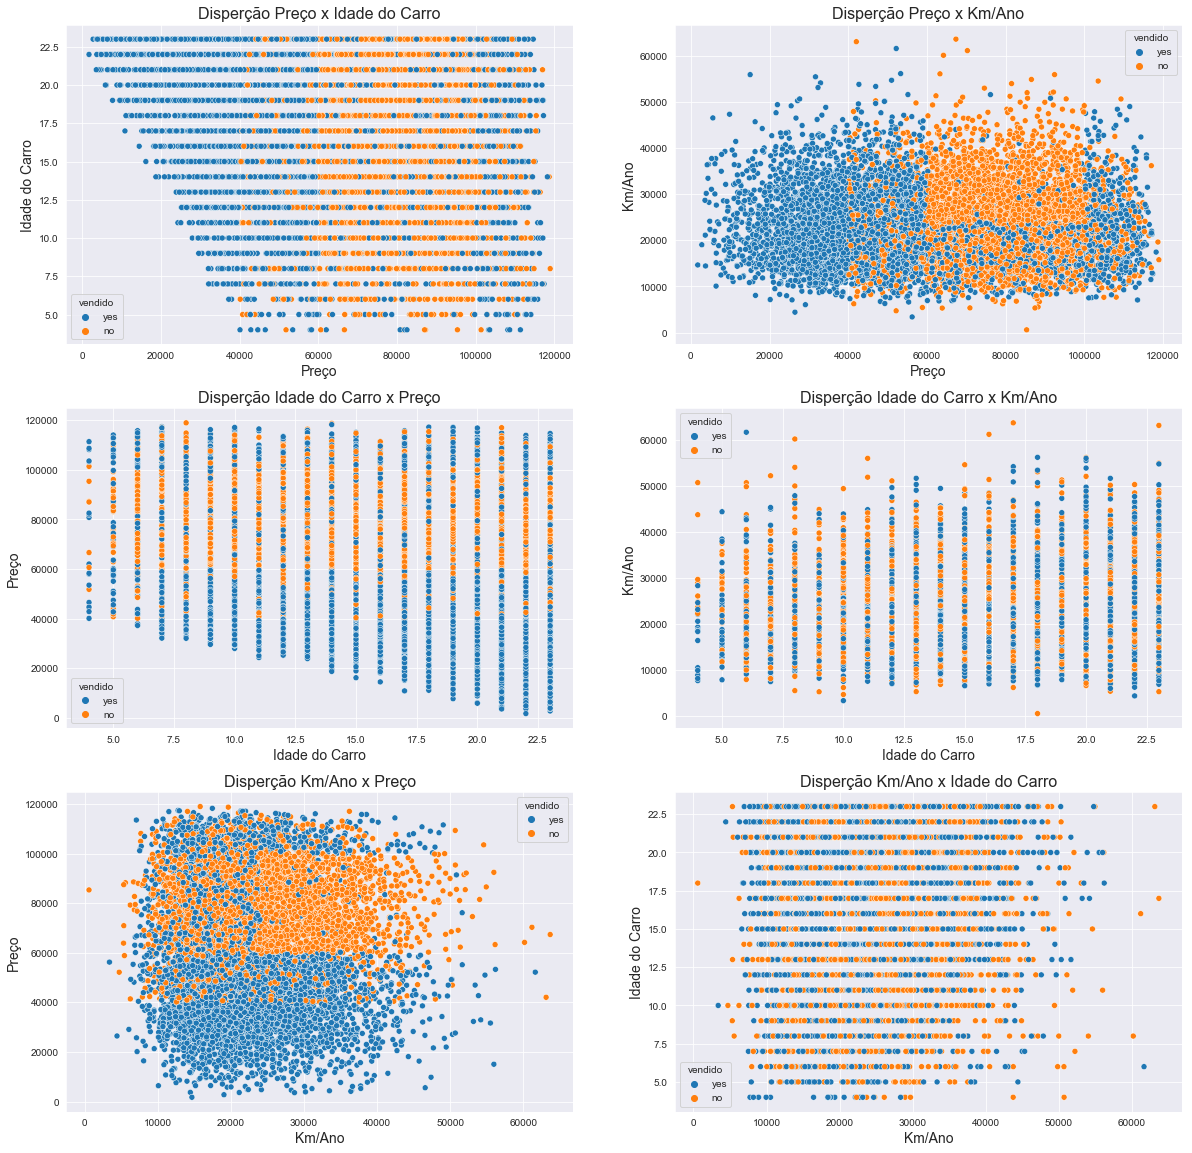

In [14]:
def scatter(titulo, xlabel, ylabel, x, y, dados):
    ax= sns.scatterplot(x= x, y= y, data= dados, hue= 'vendido')
    ax.set_title(titulo, fontsize= 16)
    ax.set_xlabel(xlabel, fontsize= 14)
    ax.set_ylabel(ylabel, fontsize= 14)
    
plt.figure(figsize= (20, 20))
plt.subplot(3, 2, 1)
scatter('Disperção Preço x Idade do Carro', 'Preço', 'Idade do Carro', 'preco', 'idade_carro', dados)

plt.subplot(3, 2, 2)
scatter('Disperção Preço x Km/Ano', 'Preço', 'Km/Ano', 'preco', 'km_por_ano', dados)

plt.subplot(3, 2, 3)
scatter('Disperção Idade do Carro x Preço', 'Idade do Carro', 'Preço', 'idade_carro', 'preco', dados)

plt.subplot(3, 2, 4)
scatter('Disperção Idade do Carro x Km/Ano', 'Idade do Carro', 'Km/Ano', 'idade_carro', 'km_por_ano', dados)

plt.subplot(3, 2, 5)
scatter('Disperção Km/Ano x Preço', 'Km/Ano', 'Preço', 'km_por_ano', 'preco', dados)

plt.subplot(3, 2, 6)
scatter('Disperção Km/Ano x Idade do Carro', 'Km/Ano', 'Idade do Carro', 'km_por_ano', 'idade_carro', dados)



**Insights**

- Os boxplots revelaram outliers apenas na variável 'Km_por_ano', porém não parecem ser valores errados.
- A maioria dos carros que possuem preço abaixo de R$ 60.000 foram vendidos.
- A proporção é crescente do número de carros vendidos conforme a idade dos carros aumenta,em relação aos não vendidos.
- O numero de carros vendidos com Km/Ano entre 15 mil e 25 mil, é quase o dobro dos carros não vendidos.

## 4. Preparação dos dados

### Selecionando as *features* e ajeitando o dataset

Vamos manter todas as variáveis independentes ```['preco', 'idade_carro', 'km_por_ano']```.

In [15]:
# Transformar a variável vendido em numérica
yes_no= {'yes': 1, 'no': 0}
dados.vendido= dados.vendido.map(yes_no)
dados.head()

y= dados.vendido
x= dados[['preco', 'idade_carro', 'km_por_ano']]
print(y.shape)
x.shape

(9998,)


(9998, 3)

### Valores Missing
Quando possuimos valores missing no dataset, nós podemos tratá-los de duas maneiras:
* Completar arbitrariamente (média, mediana, moda, etc.);
* Deletar a linha toda.

Como vimos no começo do nosso projeto, não possuimos valores nulos, não sendo necessário qualquer tratamento.

### Matriz de Correlação

In [16]:
corr= dados.corr()
corr

,preco,vendido,idade_carro,km_por_ano
preco,1.000000,-0.437750,-0.206496,-0.020468
vendido,-0.437750,1.000000,0.071650,-0.137297
idade_carro,-0.206496,0.071650,1.000000,0.016439
km_por_ano,-0.020468,-0.137297,0.016439,1.000000


Text(0.5,1,'Matriz de Correlação')

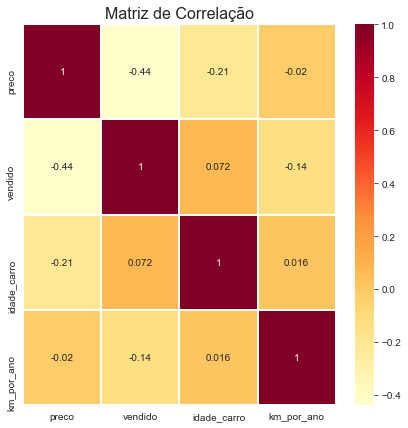

In [17]:
plt.figure(figsize= (7,7))
sns.heatmap(corr, cmap= 'YlOrRd', annot= True, linewidths= 1)
plt.title('Matriz de Correlação', fontsize= 16)

**Conclusão**

- As variáveis independentes não possuem uma forte correlação entre si.
- A variável alvo(vendido) não possui forte ligação com nenhuma outra variável.

### Separando o dataset em Treino e Teste
- Para que possamos fazer previsões, precisamos separar o nosso conjunto de dados entre treino e teste.
- Nesse projeto, iremos utilizar 70% dos dados para treino e 30% para teste.

In [18]:
# Seed global
seed= 123
np.random.seed(seed)

# Treino e Teste
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.3, stratify= y)

## 5. Construção do modelo de Machine Learning

Após entendermos melhor nossos dados, a realidade da empresa e prepararmos nossos dados, é hora de utilizarmos Machine Learning para fazer previsões que podem nos ajudar a prever a venda ou não dos carros.

Para isso, avaliaremos a accurácia de 6 modelos diferentes de Machine Learning:

>* LogisticRegression
>* RandomForest
>* DecisionTree
>* KNeighbors
>* SVC
>* AdaBoost


### Classificador  'Burro' (Dummy Classifier)

O classificador dummy nada mais é do que um classificador que utiliza regras básicas. Em outras palavras, ele vai usar algum preditor 'burro' como por exemplo predizer que todos os valores serão iguais a zero – ou a um, dependendo de qual for o mais frequente. Serve como uma linha base para classificar se o modelo de Machine Learning teve uma boa acurácia ou não.


### Validação Cruzada(Cross-Validation)

Para o resultado ser fiel a realidade e não ficar refém da sorte de uma aleatóriedade, utilizaremos validação cruzada. Para saber mais como funciona essa técnica, leia [este artigo](https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/#:~:text=A%20valida%C3%A7%C3%A3o%20cruzada%20%C3%A9%20uma,da%20modelagem%20%C3%A9%20a%20predi%C3%A7%C3%A3o.).

Nesse projeto iremos utilizar o KFold com o numero de folders igual a 10.

### Distribuição Normal

Uma das propriedades da distibuição normal é que a média somada com duas vezes o desvio padrão é igual ao percentil 97,5 e a média subtraída de 2 vezes o desvio padrão é igual ao percentil 2,5. Assim, podemos dizer que a média mais ou menos dois desvios padrões é o intervalo que contém 95% dos dados da amostra.

In [19]:
# Classificador Burro
# Vamos utilizar a regra de mais frequencia, ou seja, vamos 'chutar' todos os valores como sim(1)

dummy= DummyClassifier(strategy= 'most_frequent')
dummy.fit(x_train, y_train)
print('Linha base: {:.2f}%'.format(dummy.score(x_test, y_test)*100))

Linha base: 58.00%


In [20]:
models= []

models.append(('Logistic', LogisticRegression()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('KNeighbors', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('AdaBoost', AdaBoostClassifier()))
models

[('Logistic', LogisticRegression()),
 ('RandomForest', RandomForestClassifier()),
 ('DecisionTree', DecisionTreeClassifier()),
 ('KNeighbors', KNeighborsClassifier()),
 ('SVC', SVC()),
 ('AdaBoost', AdaBoostClassifier())]

In [21]:
np.random.seed(seed)

num_folder= 10
scoring= 'accuracy'

results= []
names=[]

for name, model in models:
    modelo= model
    kfold= KFold(n_splits= num_folder, shuffle= True)
    cv_results= cross_val_score(estimator= modelo, X= x_train, y= y_train, scoring= scoring, cv= kfold)*100
    results.append(cv_results)
    names.append(name)
    media= cv_results.mean()
    std= cv_results.std()
    print('{:12} : Acurácia média {:.2f} % , Desvio Padrão de {:.2f}% , Resultados na faxa de [{:.2f} % - {:.2f}%]'.
         format(name, media, std, media-2* std, media + 2 * std))

Logistic     : Acurácia média 64.33 % , Desvio Padrão de 2.03% , Resultados na faxa de [60.28 % - 68.38%]
RandomForest : Acurácia média 75.82 % , Desvio Padrão de 0.97% , Resultados na faxa de [73.89 % - 77.75%]
DecisionTree : Acurácia média 71.63 % , Desvio Padrão de 1.55% , Resultados na faxa de [68.53 % - 74.74%]
KNeighbors   : Acurácia média 75.46 % , Desvio Padrão de 2.09% , Resultados na faxa de [71.29 % - 79.64%]
SVC          : Acurácia média 77.02 % , Desvio Padrão de 1.89% , Resultados na faxa de [73.24 % - 80.81%]
AdaBoost     : Acurácia média 77.45 % , Desvio Padrão de 1.29% , Resultados na faxa de [74.87 % - 80.03%]


Text(0.5,0.98,'Comparação de Modelos')

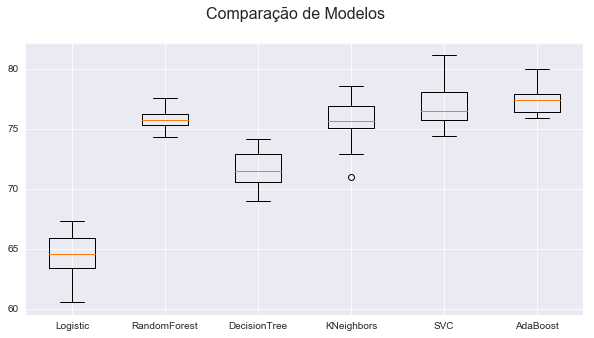

In [22]:
fig, ax = plt.subplots()
ax= fig.add_subplot()
plt.boxplot(results, labels= names)
fig.set_size_inches(10,5)
plt.suptitle('Comparação de Modelos', fontsize= 16)

### Pré-processamento e Pipeline

Suspeitando que os dados não estando na mesma escala possa ter alterado o resultado da acurácia dos modelos, utilizaremos a biblioteca Pipeline e Preprocessing para resolver esse problema.

O modelo de pré-processamento será o StandardScaler que funciona da seguinte maneira: 
* Padroniza as features removendo a média e escala a variância a uma unidade.
* Ou seja, para cada feature, a média seria 0, e o Desvio Padrão seria 1. Desta forma, as features são padronizadas, tornando-as mais manejáveis para nossos modelos.

In [23]:
pipelines= []

pipelines.append(('ScalerLogistic', Pipeline([('Scaler', StandardScaler()),('Logistic', LogisticRegression())])))
pipelines.append(('ScalerRandomForest', Pipeline([('Scaler', StandardScaler()),('RandomForest', RandomForestClassifier())])))
pipelines.append(('ScalerDecisionTree', Pipeline([('Scaler', StandardScaler()),('DecisionTree', DecisionTreeClassifier())])))
pipelines.append(('ScalerKNeighbors', Pipeline([('Scaler', StandardScaler()),('KNeighbors', KNeighborsClassifier())])))
pipelines.append(('ScalerSVC', Pipeline([('Scaler', StandardScaler()),('SVC', SVC())])))
pipelines.append(('ScalerAdaBoost', Pipeline([('Scaler', StandardScaler()),('AdaBoost', AdaBoostClassifier())])))
pipelines

[('ScalerLogistic',
  Pipeline(steps=[('Scaler', StandardScaler()),
                  ('Logistic', LogisticRegression())])),
 ('ScalerRandomForest',
  Pipeline(steps=[('Scaler', StandardScaler()),
                  ('RandomForest', RandomForestClassifier())])),
 ('ScalerDecisionTree',
  Pipeline(steps=[('Scaler', StandardScaler()),
                  ('DecisionTree', DecisionTreeClassifier())])),
 ('ScalerKNeighbors',
  Pipeline(steps=[('Scaler', StandardScaler()),
                  ('KNeighbors', KNeighborsClassifier())])),
 ('ScalerSVC', Pipeline(steps=[('Scaler', StandardScaler()), ('SVC', SVC())])),
 ('ScalerAdaBoost',
  Pipeline(steps=[('Scaler', StandardScaler()),
                  ('AdaBoost', AdaBoostClassifier())]))]

In [24]:
np.random.seed(seed)

num_folders= 10
scoring= 'accuracy'
results= []
names= []

for name, model in pipelines:
    modelo= model
    kfold= KFold(n_splits= num_folder, shuffle= True)
    cv_results= cross_val_score(estimator= model, X= x_train, y= y_train, scoring= scoring, cv= kfold)*100
    results.append(cv_results)
    names.append(name)
    media= cv_results.mean()
    std= cv_results.std()
    print('{:18} : Acurácia média {:.2f} % , Desvio Padrão {:.2f}% , Resultados na faxa de [{:.2f}% - {:.2f}%]'.
         format(name, media, std, media-2*std, media+2*std))

ScalerLogistic     : Acurácia média 70.88 % , Desvio Padrão 1.90% , Resultados na faxa de [67.08% - 74.67%]
ScalerRandomForest : Acurácia média 75.82 % , Desvio Padrão 0.97% , Resultados na faxa de [73.89% - 77.75%]
ScalerDecisionTree : Acurácia média 71.66 % , Desvio Padrão 1.48% , Resultados na faxa de [68.70% - 74.63%]
ScalerKNeighbors   : Acurácia média 73.99 % , Desvio Padrão 1.50% , Resultados na faxa de [70.99% - 76.99%]
ScalerSVC          : Acurácia média 76.68 % , Desvio Padrão 1.62% , Resultados na faxa de [73.45% - 79.91%]
ScalerAdaBoost     : Acurácia média 77.45 % , Desvio Padrão 1.29% , Resultados na faxa de [74.87% - 80.03%]


Text(0.5,0.98,'Comparação de Modelos')

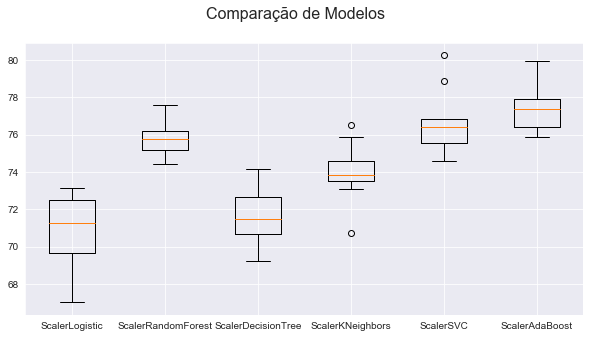

In [25]:
fig, ax = plt.subplots()
ax= fig.add_subplot()
plt.boxplot(results, labels= names)
fig.set_size_inches(10,5)
plt.suptitle('Comparação de Modelos', fontsize= 16)

### Avaliação dos resultados

Vamos analisar os resultados de cada modelo.

Sem pré-processamento: 

- **MELHOR:  AdaBoost     : Acurácia média 77.45 % , Desvio Padrão de 1.29 % , Resultados na faxa de [74.87 % - 80.03 %]**


- Logistic     : Acurácia média 64.33 % , Desvio Padrão de 2.03 % , Resultados na faxa de [60.28 % - 68.38 %]
- RandomForest : Acurácia média 75.82 % , Desvio Padrão de 0.97 % , Resultados na faxa de [73.89 % - 77.75 %]
- DecisionTree : Acurácia média 71.63 % , Desvio Padrão de 1.55 % , Resultados na faxa de [68.53 % - 74.74 %]
- KNeighbors   : Acurácia média 75.46 % , Desvio Padrão de 2.09 % , Resultados na faxa de [71.29 % - 79.64 %]
- SVC          : Acurácia média 77.02 % , Desvio Padrão de 1.89 % , Resultados na faxa de [73.24 % - 80.81 %]


Pré-processando os dados:

- **MELHOR:  ScalerAdaBoost     : Acurácia média 77.45 % , Desvio Padrão 1.29 % , Resultados na faxa de [74.87 % - 80.03 %]**


- ScalerLogistic     : Acurácia média 70.88 % , Desvio Padrão 1.90 % , Resultados na faxa de [67.08 % - 74.67 %]
- ScalerRandomForest : Acurácia média 75.82 % , Desvio Padrão 0.97 % , Resultados na faxa de [73.89 % - 77.75 %]
- ScalerDecisionTree : Acurácia média 71.66 % , Desvio Padrão 1.48 % , Resultados na faxa de [68.70 % - 74.63 %]
- ScalerKNeighbors   : Acurácia média 73.99 % , Desvio Padrão 1.50 % , Resultados na faxa de [70.99 % - 76.99 %]
- ScalerSVC          : Acurácia média 76.68 % , Desvio Padrão 1.62 % , Resultados na faxa de [73.45 % - 79.91 %]

**O modelo AdaBoost teve a melhor accurácia média e o melhor intervalo de resultados nos dois testes.**

### Avaliando o modelo AdaBoost com os dados de Teste

In [26]:
modelo= AdaBoostClassifier()

modelo.fit(x_train, y_train)
y_prev= modelo.predict(x_test)

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6891    0.8444    0.7589      1260
           1     0.8654    0.7241    0.7885      1740

    accuracy                         0.7747      3000
   macro avg     0.7773    0.7843    0.7737      3000
weighted avg     0.7914    0.7747    0.7761      3000

Acurácia: 77.47%



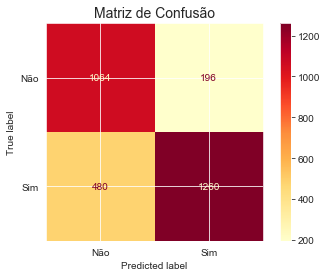

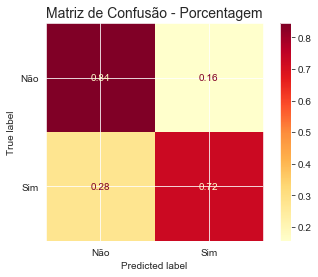

In [27]:
# Imprimindo o Relatório de Classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_prev, digits=4))

# Imprimindo a Acurácia
print("Acurácia: {:.2f}%\n".format(accuracy_score(y_test, y_prev)*100))

# Matriz de confusão 
# Normal

cm= confusion_matrix(y_test, y_prev)
labels= ['Não', 'Sim']
cmd= ConfusionMatrixDisplay(cm, display_labels= labels)
cmd.plot( cmap='YlOrRd')
plt.title('Matriz de Confusão', fontsize= 14)
plt.show()

# Porcentagem
cm= confusion_matrix(y_test, y_prev, normalize= 'true')
labels= ['Não', 'Sim']
cmd= ConfusionMatrixDisplay(cm, display_labels= labels)
cmd.plot( cmap='YlOrRd')
plt.title('Matriz de Confusão - Porcentagem', fontsize= 14)
plt.show()

## Conclusão

- Por meio do conjunto de testes, verificamos que alcançamos uma acurácia de 77,47%. Este resultado foi bem próximo às nossas expectativas, pois no treinamento alcançamos a acurácia de 77.45% e 7,47% maior do que o dono da empresa COMPRACAR estipulou.
- Ao analizar a matriz de confusão, conseguimos perceber que a maior parte dos erros são dos Falsos Negativos, que são aqueles que o modelo previu que não seriam vendidos mas foram.

## Salvando o modelo estimado

In [28]:
output = open('prev_venda_carro', 'wb')
pickle.dump(modelo, output)
output.close()

## Simulador interativo

In [29]:
model = open('prev_venda_carro','rb')
prev_venda = pickle.load(model)
model.close()

# Criando os controles do formulário
preco = widgets.Text(description="Preço")
idade_carro = widgets.Text(description="Idade Carro")
km_por_ano = widgets.Text(description="Km por Ano")

botao = widgets.Button(description="Simular")

# Posicionando os controles
left = VBox([preco, idade_carro])
right = VBox([km_por_ano])
inputs = HBox([left, right])

# Função de simulação
def simulador(sender):
    entrada=[[
                float(preco.value if preco.value else 0), 
                int(idade_carro.value if idade_carro.value else 0), 
                float(km_por_ano.value if km_por_ano.value else 0)
             ]]
    previsao= prev_venda.predict(entrada)
    if previsao == 1:
        print('A previsão é de que o carro será vendido!')
    else:
        print('Infelizmente, a previsão é de que o carro não será vendido.')
    
# Atribuindo a função "simulador" ao evento click do botão
botao.on_click(simulador)    

In [30]:
display(inputs, botao)

Button(description='Simular', style=ButtonStyle())

A previsão é de que o carro será vendido!
